#### Pre-processing

In [3]:
### TODO: DELETE THIS NOTEBOOK BEFORE SUBMISSION
### IT USES PANDAS WHICH WE'RE NOT ALLOWED TO RELY ON AFTER SUBMISSION

import json
import pandas as pd  

# load JSON logs
with open("logs/pretraining.json") as f:
    data = json.load(f)

# flatten into list of rows
rows = []
for run_name, epochs in data.items():
    for epoch_str, metrics in epochs.items():
        epoch = int(epoch_str)
        row = {"run_name": run_name, "epoch": epoch}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)
df

,run_name,epoch,train_loss,train_species_loss,train_species_Acc,train_is_animal_loss,train_is_animal_Acc,val_loss,val_species_loss,val_species_Acc,val_is_animal_loss,val_is_animal_Acc,train_breed_loss,train_breed_Acc,val_breed_loss,val_breed_Acc,train_bbox_loss,train_bbox_IoU,val_bbox_loss,val_bbox_IoU
0,cnn_species,1,0.748443,0.504276,0.556307,0.244168,0.910263,0.632314,0.480224,0.583145,0.152090,0.945071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn_species,2,0.638649,0.484662,0.578863,0.153986,0.944418,0.603429,0.480321,0.590670,0.123108,0.959368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cnn_species,3,0.606346,0.474192,0.581763,0.132154,0.957628,0.629149,0.476681,0.582393,0.152468,0.946576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cnn_species,4,0.577189,0.461143,0.592557,0.116046,0.961978,0.556611,0.445775,0.610233,0.110836,0.960873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cnn_species,5,0.569547,0.454695,0.592235,0.114853,0.962945,0.556033,0.443296,0.613995,0.112737,0.961625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,res_species_breed_bbox_50,16,0.038990,0.001324,0.833092,0.001102,0.999678,0.325644,0.012043,0.829195,0.008908,0.996990,0.031718,0.823425,0.298255,0.761475,0.004869,0.811085,0.006446,0.798581
416,res_species_breed_bbox_50,17,0.040587,0.000761,0.833253,0.000473,0.999839,0.367021,0.009643,0.831452,0.002131,0.999248,0.034893,0.823103,0.349469,0.748683,0.004457,0.816530,0.005790,0.802837
417,res_species_breed_bbox_50,18,0.036808,0.002027,0.832931,0.000245,1.000000,0.358124,0.012635,0.829195,0.004830,0.998495,0.030203,0.824553,0.334161,0.746426,0.004325,0.817951,0.006480,0.790611
418,res_species_breed_bbox_50,19,0.040406,0.003141,0.832769,0.000595,0.999839,0.347912,0.009278,0.832205,0.007423,0.997743,0.032282,0.823908,0.324416,0.751693,0.004381,0.817037,0.006794,0.792768


In [7]:
import re

### extract architecture and task
def extract_arch_task(name):
    # try matching optional prefix and suffix
    m = re.match(r"^([a-z]+)(?:_)?([a-z]+(?:_[a-z]+)*?)(?:_(\d+|[a-z]+))?$", name)
    if not m:
        return None, None
    prefix, mid, suffix = m.groups()
    if suffix and (suffix.isdigit()):
        arch = f"{prefix}{suffix}"
        task = mid
    else:
        arch = prefix
        task = mid + (f"_{suffix}" if suffix else "")
    return arch, task

df[["arch", "task"]] = df["run_name"].apply(lambda name: pd.Series(extract_arch_task(name)))

### replace inconsistent names with consistent ones
task_replacements = {
    'breed_species': 'species_breed'
}
df['task'] = df['task'].replace(task_replacements)

df[["run_name","arch", "task"]]

,run_name,arch,task
0,cnn_species,cnn,species
1,cnn_species,cnn,species
2,cnn_species,cnn,species
3,cnn_species,cnn,species
4,cnn_species,cnn,species
...,...,...,...
415,res_species_breed_bbox_50,res50,species_breed_bbox
416,res_species_breed_bbox_50,res50,species_breed_bbox
417,res_species_breed_bbox_50,res50,species_breed_bbox
418,res_species_breed_bbox_50,res50,species_breed_bbox


#### Analysis

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def best_epochs_by_metric(df: pd.DataFrame, target_metric: str) -> pd.DataFrame:
    return (
        df.loc[df.groupby("run_name")[target_metric].idxmin()]
        .reset_index(drop=True)
        .sort_values(target_metric, ascending=False)
    )

def filter_epochs(df: pd.DataFrame) -> pd.DataFrame:
    return df[((df['epoch']) % 5 == 0)]

def visualize_task_performance(best_epochs_df: pd.DataFrame, task_name: str, eval_metrics: list[str]):
    # filter for matching task_name
    df = best_epochs_df[best_epochs_df['task'] == task_name]

    if df.empty:
        print(f"no runs found for task '{task_name}'")
        return

    # set up bar chart
    x_labels = df['arch'].astype(str)  
    x = range(len(x_labels))
    width = 0.8 / len(eval_metrics)  # divide bar width over metrics

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(eval_metrics):
        if metric not in df.columns:
            print(f"warning: metric '{metric}' not in dataframe")
            continue
        offsets = [xi + i * width for xi in x]
        ax.bar(offsets, df[metric], width=width, label=metric)

    ax.set_xticks([xi + width * (len(eval_metrics) - 1) / 2 for xi in x])
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylabel("metric value")
    ax.set_title(f"Task performance for '{task_name}'")
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [9]:
print("Showing best checkpoint per run:")
best_epochs_by_metric(filter_epochs(df), 'val_loss')

Showing best checkpoint per run:


,run_name,epoch,train_loss,train_species_loss,train_species_Acc,train_is_animal_loss,train_is_animal_Acc,val_loss,val_species_loss,val_species_Acc,...,train_breed_loss,train_breed_Acc,val_breed_loss,val_breed_Acc,train_bbox_loss,train_bbox_IoU,val_bbox_loss,val_bbox_IoU,arch,task
6,cnn_species_breed_bbox,20,2.515715,0.343835,0.673917,0.075469,0.977123,2.890542,0.438685,0.615500,...,2.072450,0.257612,2.340450,0.160271,0.023964,0.591300,0.024549,0.601649,cnn,species_breed_bbox
3,cnn_breed_species,15,2.665776,0.382301,0.648945,0.081308,0.974706,2.743667,0.397465,0.645598,...,2.202167,0.222652,2.254774,0.203913,NaN,NaN,NaN,NaN,cnn,species_breed
2,cnn_breed_bbox,20,2.151224,NaN,NaN,0.068466,0.976639,2.362030,NaN,NaN,...,2.058764,0.257290,2.238833,0.211437,0.024012,0.592020,0.023748,0.589732,cnn,breed_bbox
1,cnn_breed,20,2.145737,NaN,NaN,0.072715,0.976156,2.299498,NaN,NaN,...,2.073022,0.256324,2.212843,0.190369,NaN,NaN,NaN,NaN,cnn,breed
5,cnn_species_bbox,20,0.437193,0.340160,0.678105,0.073058,0.975512,0.581992,0.439215,0.638074,...,NaN,NaN,NaN,NaN,0.023877,0.589789,0.023409,0.588162,cnn,species_bbox
4,cnn_species,15,0.442659,0.367095,0.669889,0.075564,0.977123,0.473363,0.393553,0.655380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cnn,species
11,res_breed_bbox_18,20,0.006119,NaN,NaN,0.000153,1.000000,0.400005,NaN,NaN,...,0.002802,0.833253,0.391579,0.725357,0.003177,0.841836,0.005482,0.809167,res18,breed_bbox
19,res_species_breed_bbox_18,20,0.005623,0.000273,0.833414,0.000899,0.999517,0.360310,0.008065,0.828442,...,0.001591,0.833414,0.345580,0.741159,0.002867,0.848410,0.004871,0.818215,res18,species_breed_bbox
13,res_breed_species_18,5,0.031556,0.002084,0.833253,0.001463,0.999839,0.337876,0.016035,0.828442,...,0.028009,0.829547,0.317782,0.747178,NaN,NaN,NaN,NaN,res18,species_breed
9,res_breed_18,20,0.002957,NaN,NaN,0.000111,1.000000,0.337762,NaN,NaN,...,0.002846,0.832931,0.332062,0.738149,NaN,NaN,NaN,NaN,res18,breed


Printing best-epoch-performance per run per task:


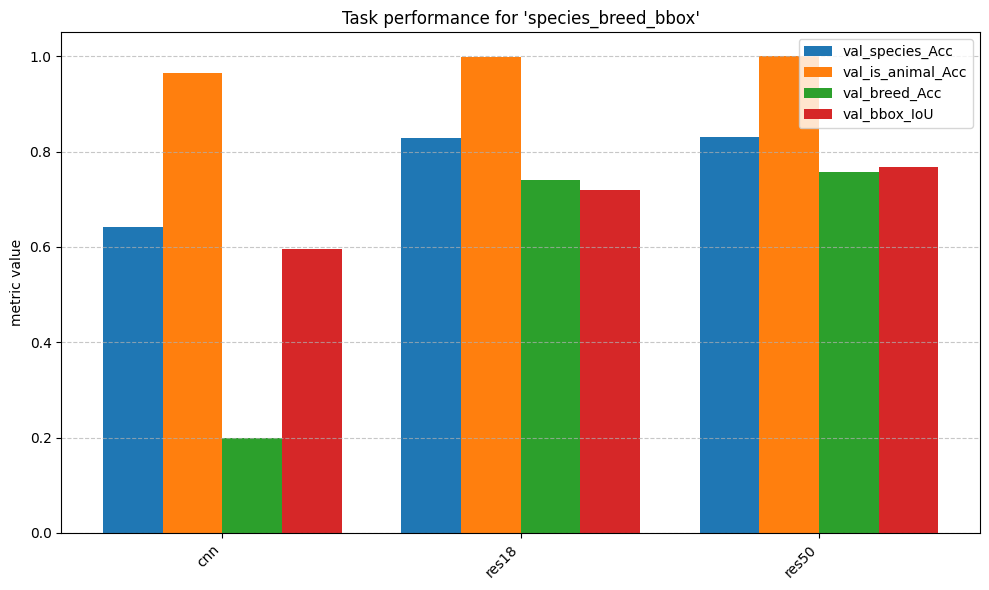

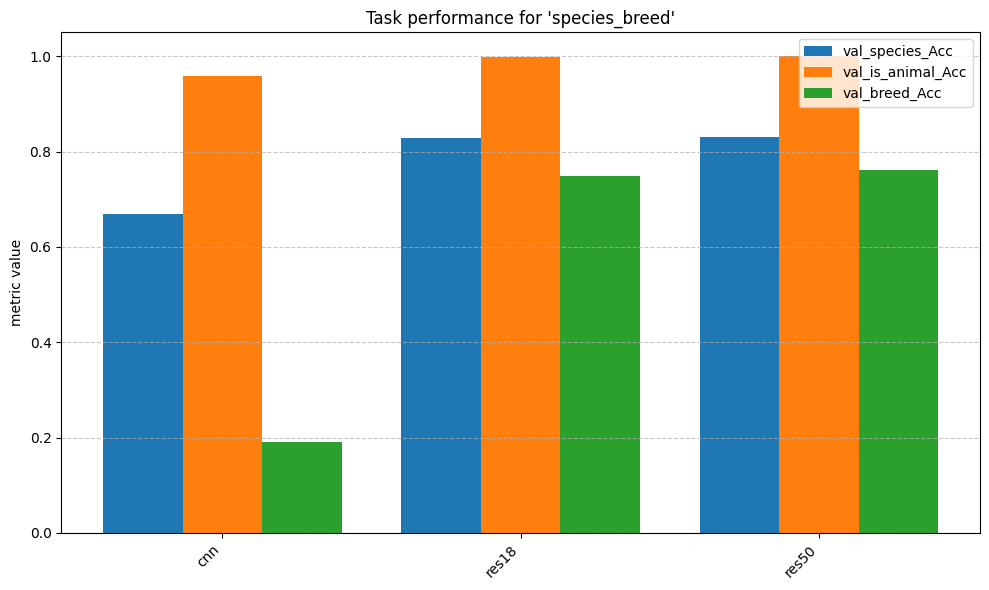

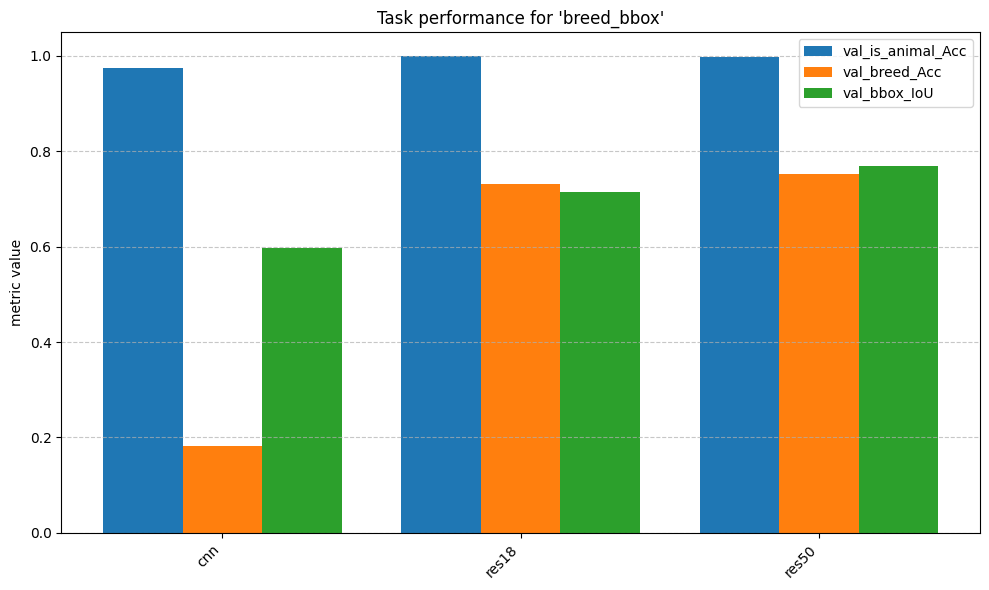

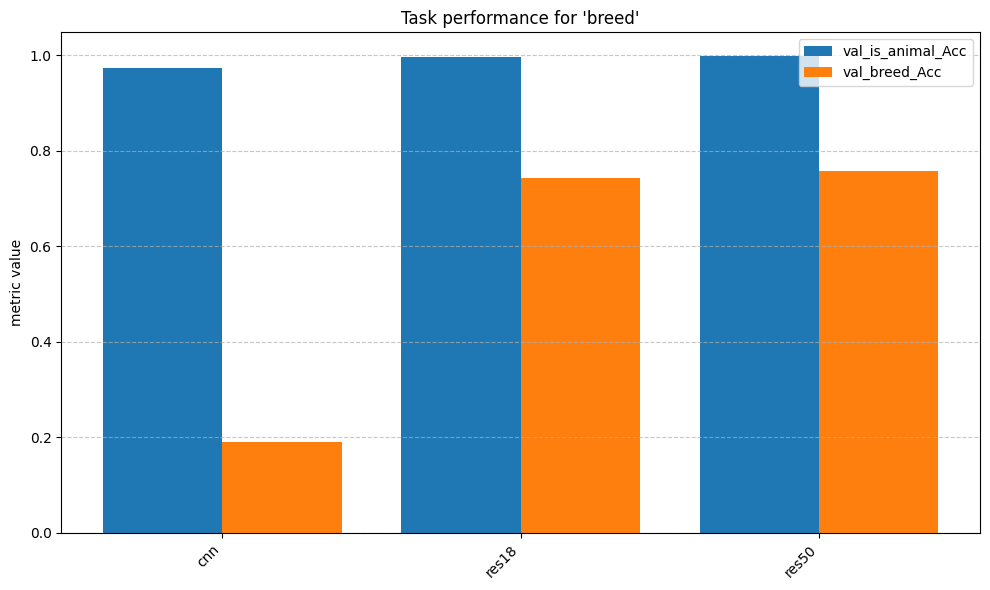

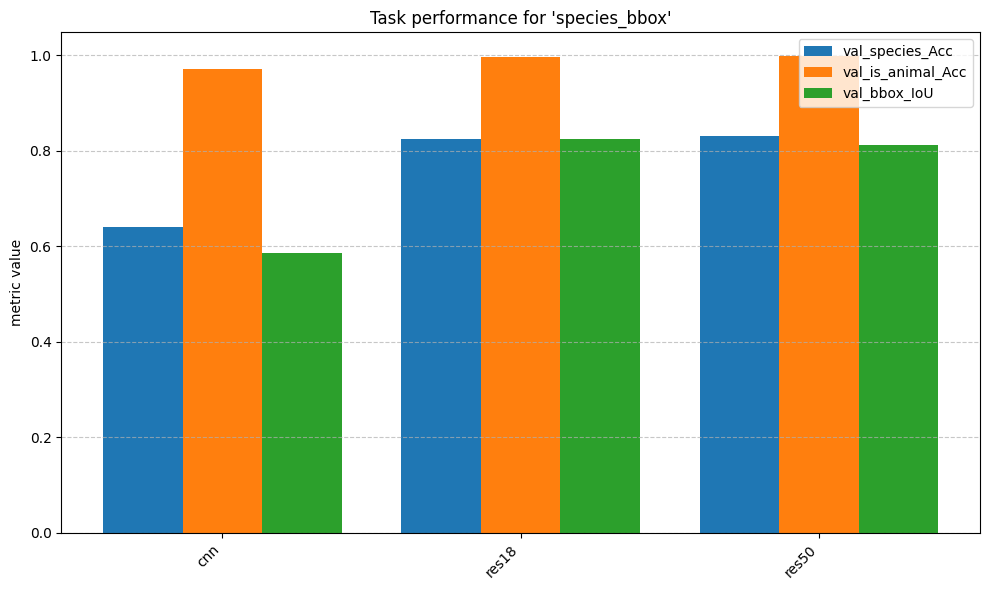

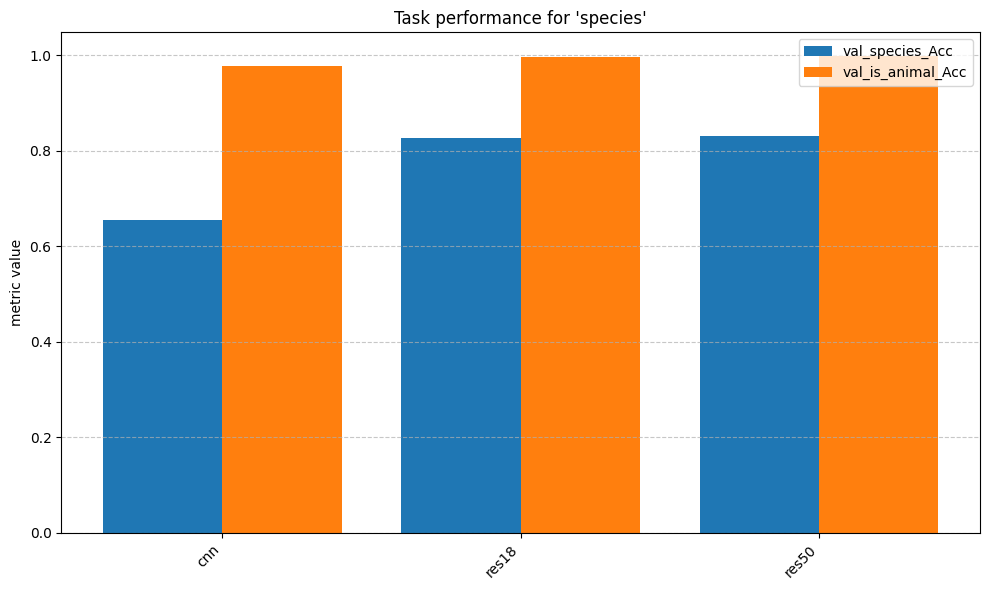

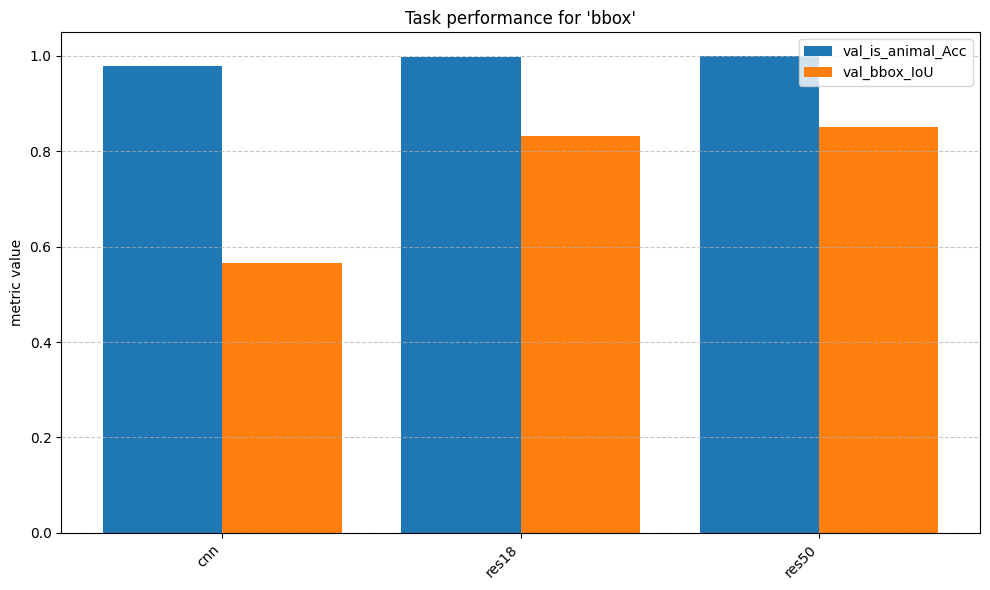

In [11]:
print("Printing best-epoch-performance per run per task:")
best_of = best_epochs_by_metric(df, 'val_loss')
metrics = [key for key in best_of.keys() if 'val' in key and 'loss' not in key]
for task in best_of['task'].unique():
    relevant_metrics = [metric for metric in metrics if not any(best_of[best_of['task'] == task][metric].isnull())]
    visualize_task_performance(best_of, task, eval_metrics=relevant_metrics)